## This draft contains reading of database properly

In [288]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 20.0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import re

from os import walk
from os.path import join

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imshow, show

In [3]:
# Read classes from file
labels = np.genfromtxt('../classes.csv', delimiter=',', dtype=str)
# because of space after comma we read redundant empty column
labels = np.array([l[0] for l in labels])

In [4]:
data_path = "../database/"
files = list()
for (dirpath, dirnames, filenames) in walk(data_path):
    files = filenames    

In [5]:
data_images = list()
data_labels = list()
label_from_name = r"([a-zA-z]+)[-_]\d+.pgm"

In [6]:
# here we load all the images and find their label from filename
for f in files:
    match = re.match(label_from_name, f)
    if match:
        label = match.groups()[0]
        if label in labels:
            data_labels.append(label)
            data_images.append(imread(join(data_path, f), as_grey=True))      
    else: 
        # if name does not match our regexp or label is not in the list
        # of classes - not read from database
        continue 

In [7]:
im = data_images[0]

In [8]:
data_labels[0]

'key'

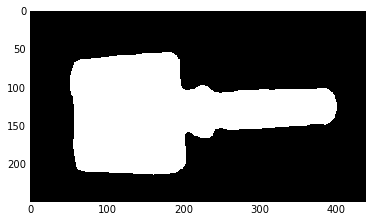

In [93]:
imshow(im)
show()

In [238]:
CONNECTIVITY_INC = {
    4: {
        0: (0, -1),
        1: (-1, 0),
        2: (0, 1),
        3: (1, 0)
    },
    8: {
        0: (0, -1),
        1: (-1, -1),
        2: (-1, 0),
        3: (-1, 1),
        4: (0, 1),
        5: (1, 1),
        6: (1, 0),
        7: (1, -1),
    }
}

In [101]:
def pad_image(im, color="b"):
    if color == "b":
        padded_im = np.array([np.concatenate([[0], row, [0]]) for row in im], dtype=np.uint8)
        new_row = np.zeros((1, padded_im.shape[1]), dtype=np.uint8)
        padded_im = np.concatenate([new_row, padded_im, new_row])
    else:
        raise ValueError("Padding is not implemented for thes color")
    return padded_im

In [271]:
def trace_border(im, connectivity=4):
    border = list()
    # we pad image by one pixel from all sides
    # padding ensures us not to go out of domain
#     padded_im = pad_image(im)
    padded_im =
    background_pixel = padded_im[0][0]
    current_pixel = padded_im[0][0]
    start = None
    
    # find starting pixel
    for i in range(padded_im.shape[0]):
        for j in range(padded_im.shape[1]):
            if padded_im[i][j] != current_pixel:
                start = (i, j)
                border.append((i, j))
                BB.append((i, j))
                break
        else:
            continue 
            # executed if the loop ended normally (no break)
        break 
        
    # iterations of the algo
    print(start)
    current_pixel = start
    direction = 0
    print("Start iteration of the algorithm... ")
    while (True):
        if connectivity == 8:
            i = (direction + 2) % 8
            while i != (direction + 7) % 8:
                next_pixel = (current_pixel[0] + CONNECTIVITY_INC[connectivity][i][0],
                              current_pixel[1] + CONNECTIVITY_INC[connectivity][i][1])
                if padded_im[next_pixel] != background_pixel:
                    current_pixel = next_pixel
                    border.append(current_pixel)
                    BB.append(current_pixel)
                    direction = (i + 4) % 8
                    break
                i = (i+1) % 8
        elif connectivity == 4:
            i = (direction + 1) % 4
            while i != (direction + 4) % 8:
                next_pixel = (current_pixel[0] + CONNECTIVITY_INC[connectivity][i][0],
                              current_pixel[1] + CONNECTIVITY_INC[connectivity][i][1])
                if padded_im[next_pixel] != background_pixel:
                    current_pixel = next_pixel
                    border.append(current_pixel)
                    BB.append(current_pixel)
                    direction = (i + 2) % 4
                    break
                i = (i+1) % 4
        else:
            raise ValueError("Invalid connectivity specified")
    # stop condition 
        if current_pixel == border[0]:
            break
            
    # remove padding from image (it will influence border coordinates)
    border = [(pixel[0] - 1, pixel[1] - 1) for pixel in border]
    
    return border

In [284]:
border = trace_border(im, connectivity=4)

(56, 173)
Start iteration of the algorithm... 


In [279]:
len(border)

1073

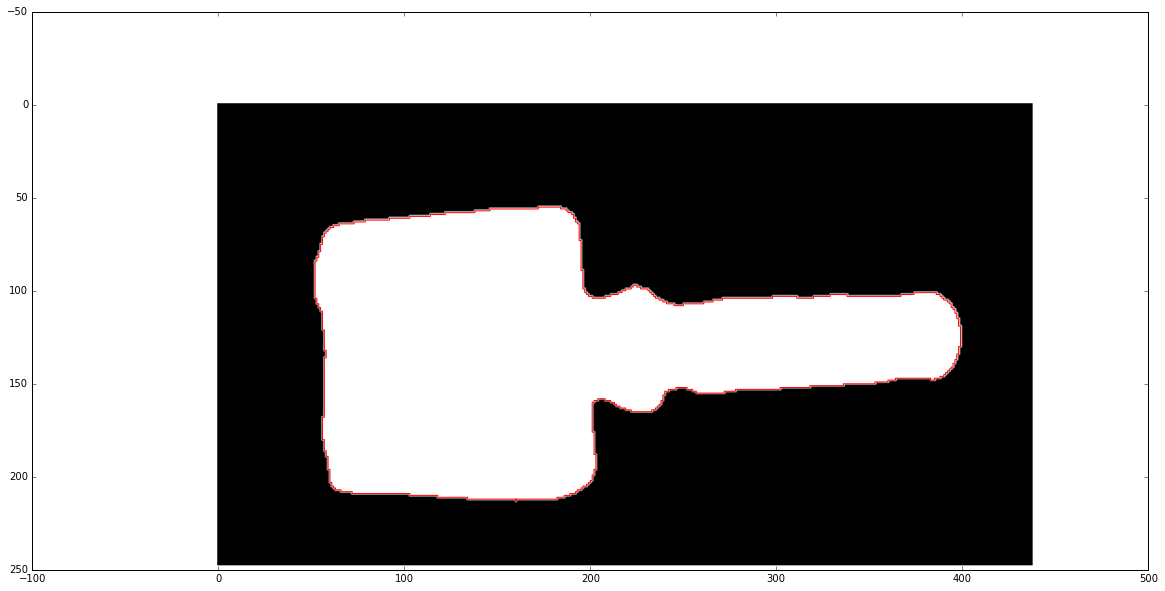

In [289]:
width = 12
height = 12
fig, ax = plt.subplots()
ax.imshow(im, cmap=plt.cm.gray)

ax.plot([b[1] for b in border], [b[0] for b in border], color="r", linewidth=1)

In [101]:
def indexing(data):
    """This function vectorizes the images with our implemented indexing method."""
#   here we can include contour finding
#   and all other things we do to find img description
#   should return np.appay that is of the same size (?) for all images
#   and each row represents image features
#   so later we can just pass it to the classifier 
    pass

In [110]:
# Later we would do:

In [106]:
# X = indexing(data_images)
# y = np.array(data_labels)

In [109]:
# clf = OneVsRestClassifier(GaussianNB())
# clf.fit(X, y)